# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('/content/drive/MyDrive/temp/9.donar choose/preprocessed_data.csv', nrows=50000)
# data = pd.read_csv('preprocessed_data.csv', nrows=50000) # you can take less number of rows like this
print(data.columns)


Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data['project_is_approved'],stratify=data['project_is_approved'], test_size=0.33)


print(X_train.shape)
print(X_test.shape)


(33500, 9)
(16500, 9)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from tqdm import tqdm   
import numpy as np 
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
X_train_essay = X_train['essay'].values
X_test_essay = X_test['essay'].values
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train_essay)
X_train_essay_tfidf= vectorizer.transform(X_train_essay)
X_test_essay_tfidf= vectorizer.transform(X_test_essay)

print(X_train_essay_tfidf.shape)


#please use below code to load glove vectors
with open('/content/drive/MyDrive/temp/9.donar choose/glove_vectors', 'rb') as f:
   model = pickle.load(f)
   glove_words = set(model.keys())
# average Word2Vec
# compute average word2vec for each review.
def avg_w2v_vec(array):
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(array): # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      cnt_words =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
         if word in glove_words:
            vector += model[word]
            cnt_words += 1
      if cnt_words != 0:
          vector /= cnt_words
      avg_w2v_vectors.append(vector)
    return avg_w2v_vectors

X_train_essay_W2V=avg_w2v_vec(X_train_essay)
X_test_essay_W2V=avg_w2v_vec(X_test_essay)

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# import nltk
# nltk.download('vader_lexicon')
def senti(array):
  sentiment=[]
  sid=SentimentIntensityAnalyzer()
  for i in array:
     score=sid.polarity_scores(i)
     value=sum(score.values())
     sentiment.append(value)
  return sentiment
X_train_senti=np.array(senti(X_train['essay'].tolist()))
X_test_senti=np.array(senti(X_test['essay'].tolist()))
X_train_sentiment=np.reshape(X_train_senti,(len(X_train_senti),1))
X_test_sentiment=np.reshape(X_test_senti,(len(X_test_senti),1))

print((X_train_senti.shape))  


(33500, 10318)


100%|██████████| 16500/16500 [00:05<00:00, 3153.46it/s]


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
(33500,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [36]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
def Response_encoding_pos_neg(df,df1,col) :
    unique = df[col].unique()
    Positive_count = []
    for i in unique : 
        Positive_count.append(len(df.loc[(df[col] == i) & (df['project_is_approved'] == 1)]))
        
        
    Negative_count = []
    for i in unique : 
        Negative_count.append(len(df.loc[(df[col] == i) & (df['project_is_approved'] == 0)]))
        
    
    encode_Pos = []
    for i in range(len(unique)) :
        encode_Pos.append(Positive_count[i]/(Positive_count[i] + Negative_count[i]))
    
    encode_Neg = []
    for i in encode_Pos:
        encode_Neg.append(1-i)
    #https://stackoverflow.com/questions/209840/how-do-i-convert-two-lists-into-a-dictionary    
    positive_final = dict(zip(unique, encode_Pos)) 
    negative_final = dict(zip(unique, encode_Neg)) 

    list_of_unique_in_test=list(set(df1[col].unique())-set(unique))
    for i in list_of_unique_in_test:
        positive_final[i]=0.5
        negative_final[i]=0.5
    return positive_final, negative_final     

def MAKING_DF_OF_TRAIN(table1,table2) : 
    pos_cleancategory, neg_cleancategory = Response_encoding_pos_neg(table1,table2,'clean_categories')
    pos_cleansubcategory, neg_cleansubcategory = Response_encoding_pos_neg(table1,table2,'clean_subcategories')
    pos_schoolstate, neg_schoolstate = Response_encoding_pos_neg(table1,table2,'school_state')
    pos_teacherprefix, neg_teacherprefix = Response_encoding_pos_neg(table1,table2, 'teacher_prefix')
    pos_projgradecategory, neg_projgradecategory = Response_encoding_pos_neg(table1,table2, 'project_grade_category')
    df = pd.DataFrame()
    df['clean_cat_pos'] = table1['clean_categories'].map(pos_cleancategory)
    df['clean_cat_neg'] = table1['clean_categories'].map(neg_cleancategory)
    df['clean_subcat_pos'] = table1['clean_subcategories'].map(pos_cleansubcategory)
    df['clean_subcat_neg'] = table1['clean_subcategories'].map(neg_cleansubcategory)
    df['school_state_pos'] = table1['school_state'].map(pos_schoolstate)
    df['school_state_neg'] = table1['school_state'].map(neg_schoolstate)
    df['teacher_prefix_pos'] = table1['teacher_prefix'].map(pos_teacherprefix)
    df['teacher_prefix_neg'] = table1['teacher_prefix'].map(neg_teacherprefix)
    df['proj_grade_cat_pos'] = table1['project_grade_category'].map(pos_projgradecategory)
    df['proj_grade_cat_neg'] = table1['project_grade_category'].map(neg_projgradecategory)

    return df

def MAKING_DF_OF_TEST(table1,table2) : 
    pos_cleancategory, neg_cleancategory = Response_encoding_pos_neg(table1,table2,'clean_categories')
    pos_cleansubcategory, neg_cleansubcategory = Response_encoding_pos_neg(table1,table2,'clean_subcategories')
    pos_schoolstate, neg_schoolstate = Response_encoding_pos_neg(table1,table2,'school_state')
    pos_teacherprefix, neg_teacherprefix = Response_encoding_pos_neg(table1,table2, 'teacher_prefix')
    pos_projgradecategory, neg_projgradecategory = Response_encoding_pos_neg(table1,table2, 'project_grade_category')
    df = pd.DataFrame()
    df['clean_cat_pos'] = table2['clean_categories'].map(pos_cleancategory)
    df['clean_cat_neg'] = table2['clean_categories'].map(neg_cleancategory)
    df['clean_subcat_pos'] = table2['clean_subcategories'].map(pos_cleansubcategory)
    df['clean_subcat_neg'] = table2['clean_subcategories'].map(neg_cleansubcategory)
    df['school_state_pos'] = table2['school_state'].map(pos_schoolstate)
    df['school_state_neg'] = table2['school_state'].map(neg_schoolstate)
    df['teacher_prefix_pos'] = table2['teacher_prefix'].map(pos_teacherprefix)
    df['teacher_prefix_neg'] = table2['teacher_prefix'].map(neg_teacherprefix)
    df['proj_grade_cat_pos'] = table2['project_grade_category'].map(pos_projgradecategory)
    df['proj_grade_cat_neg'] = table2['project_grade_category'].map(neg_projgradecategory)

    return df    


Trainsetnew = MAKING_DF_OF_TRAIN(X_train,X_test)
Testsetnew = MAKING_DF_OF_TEST(X_train,X_test)

def jointsamefeaturesposneg(table, p, n) :
    Positive = table[p].values.tolist()
    Negative = table[n].values.tolist()
    df = pd.DataFrame(list(zip(Negative, Positive)))
    
    return df


X_train_clean_cat_encoding = jointsamefeaturesposneg(Trainsetnew, 'clean_cat_pos', 'clean_cat_neg')
X_test_clean_cat_encoding = jointsamefeaturesposneg(Testsetnew, 'clean_cat_pos', 'clean_cat_neg')   

X_train_clean_sub_encoding = jointsamefeaturesposneg(Trainsetnew, 'clean_subcat_pos', 'clean_subcat_neg')
X_test_clean_sub_encoding = jointsamefeaturesposneg(Testsetnew, 'clean_subcat_pos', 'clean_subcat_neg')    

X_train_schoolstate_encoding = jointsamefeaturesposneg(Trainsetnew, 'school_state_pos', 'school_state_neg')
X_test_schoolstate_encoding = jointsamefeaturesposneg(Testsetnew, 'school_state_pos', 'school_state_neg')    

X_train_teacherprefix_encoding = jointsamefeaturesposneg(Trainsetnew, 'teacher_prefix_pos', 'teacher_prefix_neg')
X_test_teacherprefix_encoding = jointsamefeaturesposneg(Testsetnew, 'teacher_prefix_pos', 'teacher_prefix_neg')    

X_train_projgradecategory_encoding = jointsamefeaturesposneg(Trainsetnew, 'proj_grade_cat_pos', 'proj_grade_cat_neg')
X_test_projgradecategory_encoding = jointsamefeaturesposneg(Testsetnew, 'proj_grade_cat_pos', 'proj_grade_cat_neg')    

print(X_test_projgradecategory_encoding.shape)

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(X_train['price'].values.reshape(-1,1))
X_train_price_norm = scalar.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm= scalar.transform(X_test['price'].values.reshape(-1,1))
print("X_train_price_norm:",(X_train_price_norm.shape))
print("X_test_price_norm",(X_test_price_norm.shape))

scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_posted_proj_norm = scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_posted_proj_norm= scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print("X_train_posted_proj_norm:",(X_train_posted_proj_norm.shape))
print("X_test_posted_proj_norm",(X_test_posted_proj_norm.shape))



(16500, 2)
X_train_price_norm: (33500, 1)
X_test_price_norm (16500, 1)
X_train_posted_proj_norm: (33500, 1)
X_test_posted_proj_norm (16500, 1)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [35]:

from scipy.sparse import hstack
from scipy.sparse import csr_matrix

X_train_set1=hstack((X_train_clean_cat_encoding,X_train_clean_sub_encoding,X_train_schoolstate_encoding,X_train_teacherprefix_encoding,X_train_projgradecategory_encoding,X_train_posted_proj_norm,X_train_price_norm,X_train_essay_tfidf,X_train_sentiment)).tocsr()
X_test_set1=hstack((X_test_clean_cat_encoding,X_test_clean_sub_encoding,X_test_schoolstate_encoding,X_test_teacherprefix_encoding,X_test_projgradecategory_encoding,X_test_posted_proj_norm,X_test_price_norm,X_test_essay_tfidf,X_test_sentiment)).tocsr()

X_train_set2=hstack((X_train_clean_cat_encoding,X_train_clean_sub_encoding,X_train_schoolstate_encoding,X_train_teacherprefix_encoding,X_train_projgradecategory_encoding,csr_matrix(X_train_posted_proj_norm),csr_matrix(X_train_price_norm),X_train_essay_W2V)).tocsr()
X_test_set2=hstack((X_test_clean_cat_encoding,X_test_clean_sub_encoding,X_test_schoolstate_encoding,X_test_teacherprefix_encoding,X_test_projgradecategory_encoding,csr_matrix(X_test_posted_proj_norm),csr_matrix(X_test_price_norm),X_test_essay_W2V)).tocsr()


print(X_train_set1.shape)
print(X_test_set1.shape)




(33500, 10331)
(16500, 10331)


##GBDT tuning on SET1

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
XG = XGBClassifier()

parameters = {'max_depth' : [5, 10, 20, 50, 100], 'n_estimators' : [10, 25, 50, 100, 250]}

classifier = GridSearchCV(XG, parameters, cv=3,return_train_score=True,n_jobs=-1, scoring = 'roc_auc')
classifier.fit(X_train_set1,y_train)
print(classifier.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


#HEATMAP SET1 

                   mean_test_score            ... mean_train_score          
param_max_depth                5         10   ...              50        100
param_n_estimators                            ...                           
10                        0.664725  0.663420  ...         0.999783  0.999992
25                        0.693736  0.701971  ...         1.000000  1.000000
50                        0.712347  0.719119  ...         1.000000  1.000000
100                       0.722726  0.725914  ...         1.000000  1.000000
250                       0.727340  0.726792  ...         1.000000  1.000000

[5 rows x 10 columns]


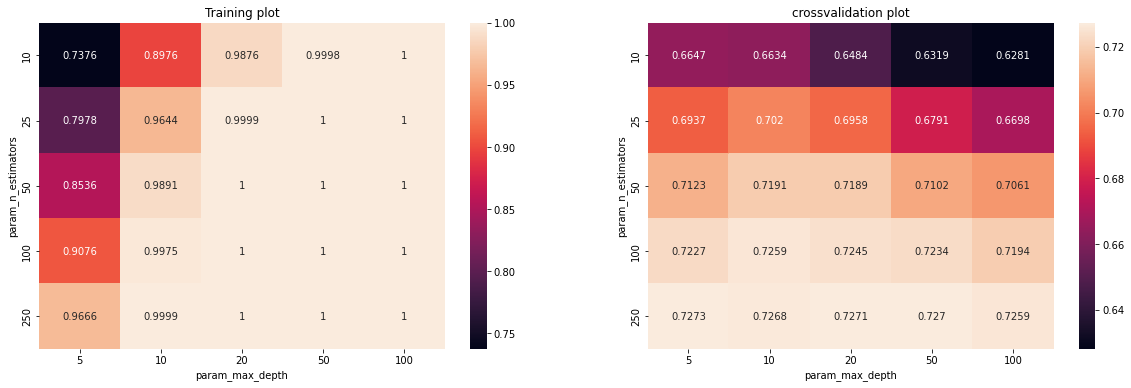

In [ ]:
#https://blog.quantinsti.com/creating-heatmap-using-python-seaborn/
import seaborn as sns
import matplotlib.pyplot as plt
score = pd.DataFrame(classifier.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]
print(score)
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(score.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(score.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training plot')
ax[1].set_title('crossvalidation plot')
plt.show()

BEST train AUC score : 0.8262418498482305
BEST test AUC score : 0.7147218532866452


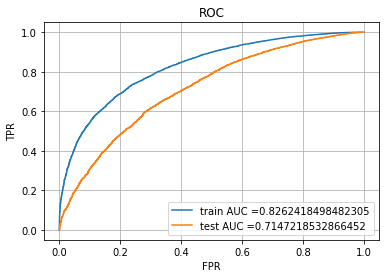

In [ ]:
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

clf_best=XGBClassifier(max_depth =5 , n_estimators = 50)
clf_best.fit(X_train_set1,y_train)
y_train_predt_set1 = clf_best.predict_proba(X_train_set1) [:,1]
y_test_predt_set1= clf_best.predict_proba(X_test_set1) [:,1]

FPR_train_s1,TPR_train_s1,thres_train_s1=roc_curve(y_train,y_train_predt_set1)
FPR_test_s1,TPR_test_s1,thres_test_s1=roc_curve(y_test,y_test_predt_set1)

print("BEST train AUC score :",auc(FPR_train_s1, TPR_train_s1))
print("BEST test AUC score :",auc(FPR_test_s1, TPR_test_s1))

plt.plot(FPR_train_s1, TPR_train_s1, label="train AUC ="+str(auc(FPR_train_s1, TPR_train_s1)))
plt.plot(FPR_test_s1, TPR_test_s1, label="test AUC ="+str(auc(FPR_test_s1, TPR_test_s1)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.grid(True)
plt.show()

##CONFUSION MATRIC FOR SET1 TEST DATA

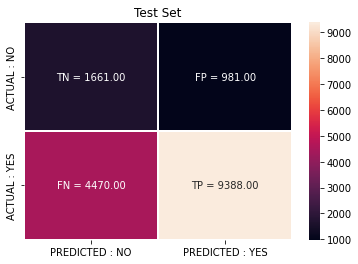

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def predict(proba, threshould, fpr, tpr):
  temp = threshould[np.argmax(fpr*(1-tpr))]
  predictions = []
  global y_testpred_s1
  for i in proba:
    if i>=temp:
       predictions.append(1)
    else:
       predictions.append(0)
  y_testpred_s1= predictions
  return predictions
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
con_m_test = confusion_matrix(y_test, predict(y_test_predt_set1, thres_test_s1, FPR_test_s1,TPR_test_s1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
#fig, ax = plt.subplots(1,2, figsize=(5,5))
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '')
plt.title('Test Set')
plt.show()


##GBDT tuning on SET2

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

XG1 = XGBClassifier()

parameters1 = {'max_depth' : [5, 10, 20, 50, 100], 'n_estimators' : [10, 25, 50, 100, 250]}

classifier1 = GridSearchCV(XG1, parameters1, cv=3,return_train_score=True,n_jobs=-1, scoring = 'roc_auc')
classifier1.fit(X_train_set2,y_train)
print(classifier1.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


#HEATMAP SET2

                   mean_test_score            ... mean_train_score          
param_max_depth                5         10   ...              50        100
param_n_estimators                            ...                           
10                        0.665589  0.658676  ...          0.99984  0.999815
25                        0.689742  0.682147  ...          1.00000  1.000000
50                        0.706102  0.699756  ...          1.00000  1.000000
100                       0.713637  0.707988  ...          1.00000  1.000000
250                       0.711973  0.714726  ...          1.00000  1.000000

[5 rows x 10 columns]


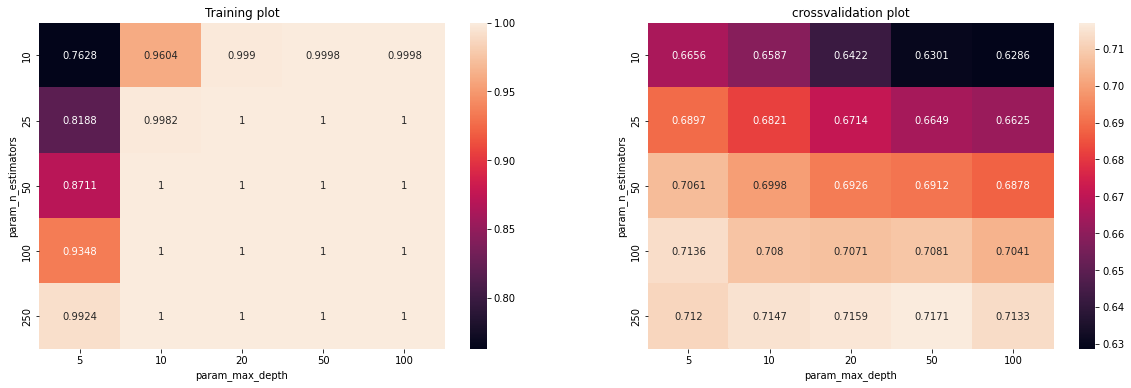

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

score1 = pd.DataFrame(classifier1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]
print(score1)
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(score1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(score1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training plot')
ax[1].set_title('crossvalidation plot')
plt.show()

BEST train AUC score : 0.8335621076056047
BEST test AUC score : 0.7075944076006568


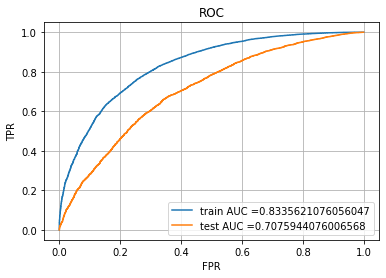

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

clf_best1=XGBClassifier(max_depth =5 , n_estimators = 50)
clf_best1.fit(X_train_set2,y_train)
y_train_predt_set2 = clf_best1.predict_proba(X_train_set2) [:,1]
y_test_predt_set2= clf_best1.predict_proba(X_test_set2) [:,1]

FPR_train_s2,TPR_train_s2,thres_train_s2=roc_curve(y_train,y_train_predt_set2)
FPR_test_s2,TPR_test_s2,thres_test_s2=roc_curve(y_test,y_test_predt_set2)

print("BEST train AUC score :",auc(FPR_train_s2, TPR_train_s2))
print("BEST test AUC score :",auc(FPR_test_s2, TPR_test_s2))

plt.plot(FPR_train_s2, TPR_train_s2, label="train AUC ="+str(auc(FPR_train_s2, TPR_train_s2)))
plt.plot(FPR_test_s2, TPR_test_s2, label="test AUC ="+str(auc(FPR_test_s2, TPR_test_s2)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.grid(True)
plt.show()

##CONFUSION MATRIC FOR SET2 TEST DATA

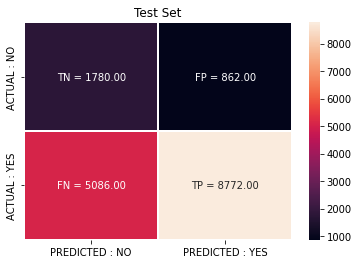

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def predict1(proba, threshould, fpr, tpr):
  temp = threshould[np.argmax(fpr*(1-tpr))]
  predictions = []
  
  for i in proba:
    if i>=temp:
       predictions.append(1)
    else:
       predictions.append(0)
  return predictions
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
con_m_test1= confusion_matrix(y_test, predict1(y_test_predt_set2, thres_test_s2, FPR_test_s2,TPR_test_s2))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
#fig, ax = plt.subplots(1,2, figsize=(5,5))
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test1.flatten())])).reshape(2,2)
sns.heatmap(con_m_test1, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '')
plt.title('Test Set')
plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [ ]:
#https://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["MODEL used", "MAX DEPTH", "N-estimator", " TRAIN AUC", "TEST AUC"
]
x.add_row(["SET1-TFIDF", 5, 50,0.82,0.71])
x.add_row(["SET2-W2V",5,50, 0.83,0.70])
print(x)


+------------+-----------+-------------+------------+----------+
| MODEL used | MAX DEPTH | N-estimator |  TRAIN AUC | TEST AUC |
+------------+-----------+-------------+------------+----------+
| SET1-TFIDF |     5     |      50     |    0.82    |   0.71   |
|  SET2-W2V  |     5     |      50     |    0.83    |   0.7    |
+------------+-----------+-------------+------------+----------+
